<a href="https://colab.research.google.com/github/Renan-Domingues/WhatIsTorch.nnReally/blob/main/Torch_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is torch.nn Really?
To devolop a understand of modules and classes we will train firs a basic neural network

### MNIST data setup

we'll use a dataset which consist in black and white hand-drawn digits called MNIST

In [ ]:
from pathlib import Path # for dealing with paths
import requests # to download a dataset

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = 'mnist.pkl.gz'

if not (PATH / FILENAME).exists():
  content = requests.get(URL + FILENAME).content
  (PATH / FILENAME).open("wb").write(content)

In [ ]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and been stored as a flattened row of 784(28*28), we need reshape ir ro 2d first.

(50000, 784)


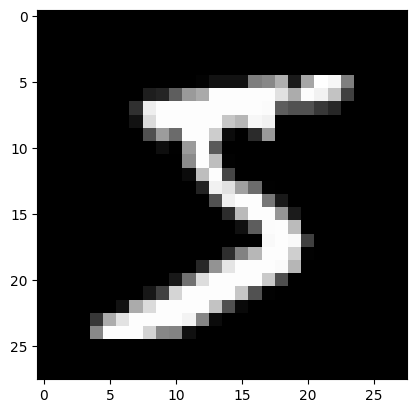

In [ ]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")

try:
  import google.colab
except ImportError:
  pyplot.show()

print(x_train.shape)

In [ ]:
# converting data from numpy to tensor

import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# Neural net from scratch (without torch.nn)

Creating a model using just pytorch tensor operations

In [ ]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_() # the _ in the end, means that is in-line
bias = torch.zeros(10, requires_grad=True)


Now we'll  create a simple linear model. We also need a activstion function, so we'll write log_softmax and use it

In [ ]:
def log_softmax(x):
  return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
  return log_softmax(xb @ weights + bias) # the @ stands for the matrix multiplication

In [ ]:
# We will call our function on one batch data (64 images)
bs = 64 # batch size

xb = x_train[0:bs] # a mini-batch from x
preds = model(xb) # prediction
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.2493, -1.9948, -2.0345, -2.5092, -3.0467, -2.4902, -2.6541, -2.2848,
        -2.1520, -2.0590], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [ ]:
# inplementing the loss function

def nll(input, target):
  return -input[range(target.shape[0]), target].mean()

loss_func = nll

let's check our loss function with our random module, so we can see if we improve after a backprop pass lather.

In [ ]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4266, grad_fn=<NegBackward0>)


Lets calculate the prediction of our model. For each prediction, if the index with the largest value matches the target, the prediction is correct

In [ ]:
def accuracy(out,  yb):
  preds = torch.argmax(out, dim=1)
  return (preds == yb).float().mean()

In [ ]:
print(accuracy(preds, yb))

tensor(0.0781)


We'll desable the gradient to update weights and bias
because we don't want these steps to be recorded for the next calculation

In [ ]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
  for i in range((n - 1) // bs + 1):
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    with torch.no_grad():
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()


In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb)) # checking loss and accuracy

tensor(0.0819, grad_fn=<NegBackward0>) tensor(1.)


# Using torch.nn.functional

to make our code shorter, we'll replace our hand-written activation and loss function with those from torch.nn.functional

If you're using negative log likelihood loss and log softmax activation, then Pytorch provides a single function "F.cross_entropy" that combines the two. So we can even remove the activation function from our model.

In [ ]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
  return  xb @ weights + bias


In [ ]:
# Now that we are not using log_softmax in the model, lets test if our accuracy and loss are the same as before

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0819, grad_fn=<NllLossBackward0>) tensor(1.)


# Refactor using nn.Module

We want to create a class that holds our weights, bias, and methods for the forward step

In [ ]:
from torch import nn

class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
    self.bias = nn.Parameter(torch.zeros(10))

  def forward(self, xb):
    return xb @ self.weights + self.bias

In [ ]:
# now that we are using an object insted of a function, we have to instantiate our model


model = Mnist_Logistic()

In [ ]:
# calculate the loss, the same way as before

print(loss_func(model(xb), yb))

tensor(2.2919, grad_fn=<NllLossBackward0>)


Now we can use model.parameters() and model.zero_grad(), because they are defined by Pytorch for nn.Module

In [ ]:
def fit():
  for epoch in range(epochs):
    for i in range((n-1) // bs+1):
      start_i = i * bs
      end_i = start_i + bs
      xb = x_train[start_i:end_i]
      yb = y_train[start_i:end_i]
      pred = model(xb)
      loss = loss_func(pred, yb)

      loss.backward()
      with torch.no_grad():
        for p in model.parameters():
          p -= p.grad * lr
        model.zero_grad()

fit()

In [ ]:
# checking if the loss has gone down
print( loss_func(model(xb), yb))

tensor(0.0803, grad_fn=<NllLossBackward0>)


# Refactor using nn.Linear

Now we'll use nn.Linear instead of self.weights and self.bias, and calculating xb @ self.weights + self.bias

it will simplify our code and often makes it faster

In [ ]:
class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin = nn.Linear(784, 10)

  def forward(self, xb):
    return self.lin(xb)



In [ ]:
# instanciate our model and calculate the loss  the same way as before

model = Mnist_Logistic()

print(loss_func(model(xb), yb))

tensor(2.3087, grad_fn=<NllLossBackward0>)


In [ ]:
# we can still use our same fit method as before

fit()
print(loss_func(model(xb), yb))

tensor(0.0816, grad_fn=<NllLossBackward0>)


# Refactor using torch.optim

torch.optim = PyTorch's optimization algorithms

In [ ]:
from torch import optim

In [ ]:
def get_model():
  model = Mnist_Logistic()
  return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range (epochs):
  for i in range((n - 1) // bs + 1):
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3902, grad_fn=<NllLossBackward0>)
tensor(0.0825, grad_fn=<NllLossBackward0>)


# Refactor using Dataset

In [ ]:
from torch.utils.data import TensorDataset



In [ ]:
# the x_train and y_train can be combined in a single TensorDataset (easier to iterate)

train_ds = TensorDataset(x_train, y_train)


In [ ]:
model, opt = get_model()

for epoch in range(epochs):
  for i in range((n - 1) // bs + 1):
    xb, yb = train_ds[i * bs: i * bs + bs]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0806, grad_fn=<NllLossBackward0>)


# Refactor using DataLoader
Dataloader create batches from datasets and menage them

In [ ]:
from torch.utils.data import DataLoader
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)


In [ ]:
model, opt = get_model()

for epoch in range(epochs):
  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0802, grad_fn=<NllLossBackward0>)


# add validation
validation is inportant to identify if I'm overfitting.



In [ ]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)


In [ ]:
model, opt = get_model()

for epoch in range(epochs):
  model.train()
  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

  model.eval()
  with torch.no_grad():
    valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

  print(epoch, valid_loss / len(valid_dl))


0 tensor(0.2857)
1 tensor(0.2924)


# Create fit() and get_data()

we are using loss for the training and the test, so let's make a function to it

we pass a optimizer in the training set but not in the validation set (so the method don't perform backprop).

In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
  loss = loss_func(model(xb), yb)

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()

  return loss.item(), len(xb)

In [ ]:
# fit runs the necessary operations to train our model and compute the training and validation losses for each epoch.

import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      loss_batch(model, loss_func, xb, yb, opt)

    model.eval()
    with torch.no_grad():
      losses, nums = zip(
          *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
      )
    val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

    print(epoch, val_loss)

In [ ]:
# get_data returns dataloaders for the training and validation set
def get_data(train_ds, valid_ds, bs):
  return(
      DataLoader(train_ds, batch_size=bs, shuffle=True),
      DataLoader(valid_ds, batch_size=bs *2)
  )

In [ ]:
# now the whole process of obtain data loaders and fitting the model is in few lines

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.33256124439239504
1 0.3287441743016243


# Switch to CNN (Convolutional Neural Network)

we'll build our neural network whith 3 convolutional Layers

In [ ]:
class Mnist_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

  def forward(self, xb):
    xb = xb.view(-1, 1, 28, 28)
    xb = F.relu(self.conv1(xb))
    xb = F.relu(self.conv2(xb))
    xb = F.relu(self.conv3(xb))
    xb = F.avg_pool2d(xb, 4)
    return xb.view(-1,  xb.size(1))

lr = 0.1

Momentum is a variation on stochastic gradient descent that takes previous updates into account as well and generally leads to faster training.

In [ ]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.34851064043045044
1 0.24465843169689178


# Using nn.Sequential
runs a sequential of each  model contained within it

In [ ]:
class Lambda(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, x):
    return self.func(x)

def preprocess(x):
  return x.view(-1, 1, 28, 28)


In [ ]:
# the model created with senquential

model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.33417297912836075
1 0.24789979419112204


# Wrapping DataLoader

our model will only  work with MNIST because its assumes the input 28x28 long vector and that the final CNN grid size is 4x4

Let's get rid of these asssumptions, so our model works with any 2d single channel image

In [ ]:

def preprocess(x, y):
  return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
  def __init__(self, dl, func):
    self.dl = dl
    self.func = func

  def __len__(self):
    return len(self.dl)

  def __iter__(self):
    for b in self.dl:
      yield (self.func(*b))


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)


Next, we can replace nn.AvgPool2d with nn.AdaptiveAvgPool2d, which allows us to define the size of the output tensor we want. Our model will work with any size input

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


In [ ]:
# let's try out
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4150223785877228
1 0.27101551288366316


# Using your GPU

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# moving batchs to the gpu:
def preprocess(x, y):
  return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [ ]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
# is it faster now?
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.21472426335811615
1 0.20959358631372452
